In [8]:

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.statespace.sarimax import SARIMAX


The main function of this code is to check whether the annual data of each monitoring site is complete and to output a summary table. 

Read the data file (annually COTS.csv) and ensure that there are no extra spaces in the column names. 
Extract the year from the date column. If the year cannot be identified, an error message will be displayed for prompt. 

Check if the "site name" column exists and retain the key fields (site name, year, sea star density). 

Output the summary results, print them on the console and save them as the "step2_site_coverage_summary.csv" file. 

Finally, print the total number of sites, the list of site names, and the overall year range.

In [9]:

# Step 1 - Group by site and check annual data completeness
DATA_PATH = Path("annually COTS.csv")

df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()

if "date" not in df.columns:
    raise ValueError("Column 'date' not found. Please check the header or adjust the parsing logic.")

# Extract year (four digits) from 'date' column
year_series = (
    df["date"].astype(str)
      .str.extract(r"(\d{4})")[0]
      .astype(float)
)
if year_series.isna().all():
    raise ValueError("Failed to extract year from 'date' column. Please check the date format (should contain a four-digit year).")

df["year"] = year_series.astype("Int64")
df = df.dropna(subset=["year"])
df["year"] = df["year"].astype(int)

site_col = "site name"
if site_col not in df.columns:
    raise ValueError("Column 'site name' not found. Please check the header.")

# Keep only necessary columns
keep_cols = set([site_col, "year"])
if "MEAN_COTS_PER_TOW" in df.columns:
    keep_cols.add("MEAN_COTS_PER_TOW")
df = df[list(keep_cols)]

# Summarize data coverage by site
expected_years = list(range(2011, 2019))
summary = []
for site, sub in df.groupby(site_col):
    years = sorted(sub["year"].unique().tolist())
    missing = [y for y in expected_years if y not in years]
    mean_target = (
        sub["MEAN_COTS_PER_TOW"].mean()
        if "MEAN_COTS_PER_TOW" in sub.columns else np.nan
    )
    summary.append({
        "site_name": site,
        "n_records": len(sub),
        "year_min": min(years) if years else None,
        "year_max": max(years) if years else None,
        "year_range": f"{min(years)}–{max(years)}" if years else "NA",
        "missing_years": ",".join(map(str, missing)) if missing else "",
        "mean_MEAN_COTS_PER_TOW": mean_target
    })

summary_df = pd.DataFrame(summary).sort_values("site_name").reset_index(drop=True)

print("\n=== Step 2 - Annual data coverage per site (2011–2018) ===")
print(summary_df.to_string(index=False))

# Save summary table
out_path = DATA_PATH.parent / "step2_site_coverage_summary.csv"
summary_df.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"\nSummary table saved to: {out_path.resolve()}")

# Print global info
n_sites = df[site_col].nunique()
sites = sorted(df[site_col].unique().tolist())
print(f"\nNumber of sites: {n_sites}")
print("Site list:", sites)
print(f"Year range: {df['year'].min()}–{df['year'].max()}")



=== Step 2 - Annual data coverage per site (2011–2018) ===
             site_name  n_records  year_min  year_max year_range missing_years  mean_MEAN_COTS_PER_TOW
AGINCOURT REEFS (NO 1)          8      2011      2018  2011–2018                               0.00000
       BROOMFIELD REEF          8      2011      2018  2011–2018                               0.00000
  CHINAMAN REEF(22102)          8      2011      2018  2011–2018                               0.72225
         EAST CAY REEF          8      2011      2018  2011–2018                               0.06800
         HASTINGS REEF          8      2011      2018  2011–2018                               0.00225
              RIB REEF          8      2011      2018  2011–2018                               0.90650

Summary table saved to: /home/step2_site_coverage_summary.csv

Number of sites: 6
Site list: ['AGINCOURT REEFS (NO 1)', 'BROOMFIELD REEF', 'CHINAMAN REEF(22102)', 'EAST CAY REEF', 'HASTINGS REEF', 'RIB REEF']
Year rang

The following code performs the conversion and cleaning of the original flow velocity and wind speed vectors into scalar form, preparing clean input data for subsequent PCA and time series modeling.

In [10]:

# Step 2 - Calculate current speed and wind speed magnitudes
IN_PATH  = Path("annually COTS.csv")
OUT_PATH = Path("annually COTS_mix.csv")

df = pd.read_csv(IN_PATH)
df.columns = [c.strip().lstrip("\ufeff") for c in df.columns]

# Standardize site name column
if "site name" in df.columns:
    df = df.rename(columns={"site name": "site"})

# Parse date column
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Convert numeric columns to numeric types
numeric_cols = [
    "eta","salt","temp","u","v",
    "wspeed_u","wspeed_v",
    "DIN","DIP","Dust","PH","Oxygen","Chl",
    "TOTAL_COTS","MEAN_COTS_PER_TOW","TOWS"
]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Compute current speed magnitude
if {"u", "v"}.issubset(df.columns):
    df["current_speed"] = np.hypot(df["u"], df["v"])
else:
    df["current_speed"] = np.nan

# Compute wind speed magnitude
if {"wspeed_u", "wspeed_v"}.issubset(df.columns):
    df["wind_speed"] = np.hypot(df["wspeed_u"], df["wspeed_v"])
else:
    df["wind_speed"] = np.nan

# Drop unnecessary columns
drop_cols = ["u", "v", "wspeed_u", "wspeed_v"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# Save output
df.to_csv(OUT_PATH, index=False, encoding="utf-8")
print(f"[OK] File generated: {OUT_PATH}")
print("Example columns:", [c for c in df.columns[:15]])


[OK] File generated: annually COTS_mix.csv
Example columns: ['date', 'site', 'eta', 'salt', 'temp', 'DIN', 'DIP', 'Dust', 'PH', 'Oxygen', 'Chl', 'TOTAL_COTS', 'MEAN_COTS_PER_TOW', 'TOWS', 'current_speed']


Then, a principal component analysis (PCA) was conducted on the sea star density (MEAN_COTS_PER_TOW) and its environmental variables to extract the main ecological change axes. 

Read the cleaned data file, standardize the data (with a mean of 0 and a standard deviation of 1) to avoid the influence of dimensional differences on the analysis results. 

Perform PCA dimensionality reduction, extract the first two principal components (PC1, PC2), and calculate the variance proportions they explain. 

Draw a scatter plot (PCA scatter) to show the distribution of the samples in the principal component space. 
Draw a biplot, using arrows to indicate the direction and magnitude of the contribution of each environmental factor to the principal components. 

Finally, two image files are output to help understand which environmental factors are most closely related to the changes in starfish density.

Explained variance ratio: PC1=0.485, PC2=0.194

 Overall PCA completed. Figures saved as:
 - PCA_overall_scatter.png
 - PCA_overall_biplot.png


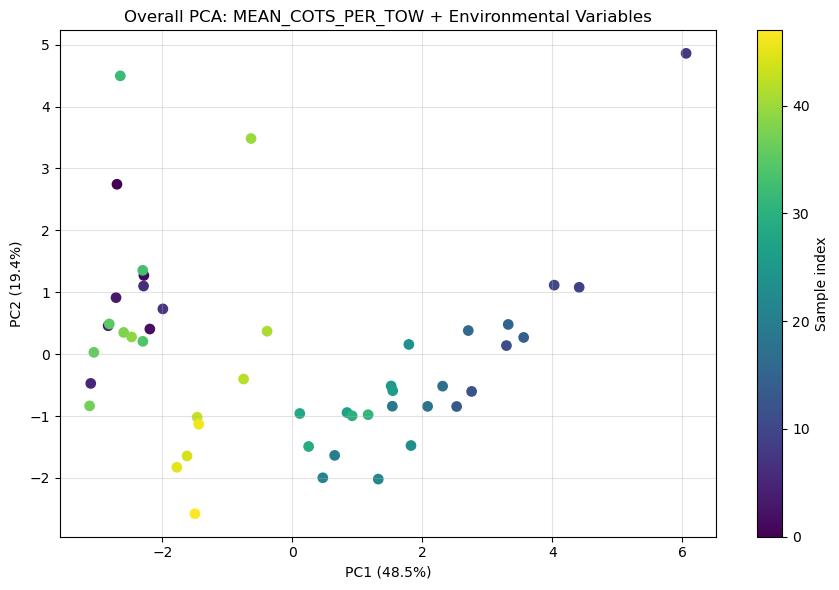

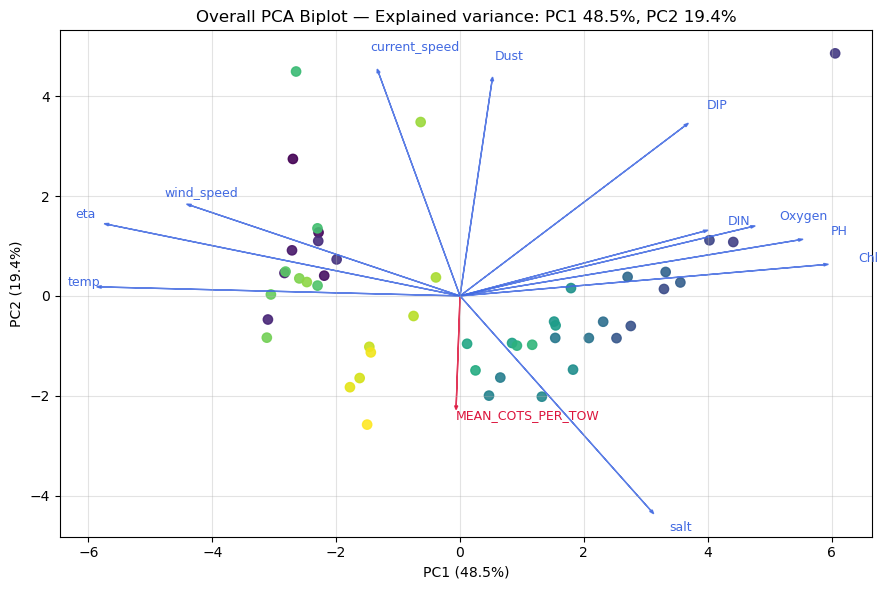

In [11]:

# Step 3 - Overall PCA Analysis
df = pd.read_csv("annually COTS_mix.csv")
df.columns = [c.strip().lstrip("\ufeff") for c in df.columns]

target_col = "MEAN_COTS_PER_TOW"
env_vars = ["eta","salt","temp","DIN","DIP","Dust","PH","Oxygen","Chl","current_speed","wind_speed"]

# Check for missing columns
missing = [c for c in [target_col] + env_vars if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns: {missing}")

# Prepare numeric data
X = df[[target_col] + env_vars].copy()
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors="coerce")
X = X.replace([np.inf, -np.inf], np.nan).interpolate(limit_direction="both").dropna()

# Standardize data
scaler = StandardScaler()
Z = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2, random_state=0)
PC = pca.fit_transform(Z)
exp = pca.explained_variance_ratio_
print(f"Explained variance ratio: PC1={exp[0]:.3f}, PC2={exp[1]:.3f}")

pc_df = pd.DataFrame(PC, columns=["PC1", "PC2"])
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
load_df = pd.DataFrame(loadings, index=X.columns, columns=["PC1","PC2"])

# Plot PCA scatter
plt.figure(figsize=(9,6))
plt.scatter(pc_df["PC1"], pc_df["PC2"], c=np.arange(len(pc_df)), cmap="viridis", s=45)
plt.xlabel(f"PC1 ({exp[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({exp[1]*100:.1f}%)")
plt.title("Overall PCA: MEAN_COTS_PER_TOW + Environmental Variables")
plt.colorbar(label="Sample index")
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.savefig("PCA_overall_scatter.png", dpi=300)
plt.show()

# Plot PCA biplot
sx = (pc_df["PC1"].max() - pc_df["PC1"].min()) * 0.8
sy = (pc_df["PC2"].max() - pc_df["PC2"].min()) * 0.8
scale = min(sx, sy) / (np.max(np.abs(loadings)) + 1e-9)

plt.figure(figsize=(9,6))
plt.scatter(pc_df["PC1"], pc_df["PC2"], c=np.arange(len(pc_df)), cmap="viridis", s=45, alpha=0.9)
for var, (lx, ly) in load_df.iterrows():
    dx, dy = lx * scale, ly * scale
    color = 'crimson' if var == target_col else 'royalblue'
    plt.arrow(0, 0, dx, dy, color=color, alpha=0.85, width=0.0, head_width=0.05, length_includes_head=True)
    plt.text(dx * 1.08, dy * 1.08, var, color=color, fontsize=9)
plt.xlabel(f"PC1 ({exp[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({exp[1]*100:.1f}%)")
plt.title(f"Overall PCA Biplot — Explained variance: PC1 {exp[0]*100:.1f}%, PC2 {exp[1]*100:.1f}%")
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.savefig("PCA_overall_biplot.png", dpi=300)
plt.show()

print("\n Overall PCA completed. Figures saved as:")
print(" - PCA_overall_scatter.png")
print(" - PCA_overall_biplot.png")


Next, using the SARIMAX time series model and the principal components (PC1, PC2) obtained through PCA, the temporal trend of sea star density was predicted. 

Organize input data: Combine the principal components output by PCA with the target variable into a time series based on the date. 

Constructing lagging variables: Create PC1 and PC2 for the previous time step, allowing the model to learn the temporal dependencies. 

Apply the logarithmic transformation (log1p) to the target variable to reduce the influence of extreme values and improve the stability of the model. 

Automatically identify the data frequency and accordingly set the seasonal parameters (for annual data, it is set to 0). 

Divide the training set and the test set. Fit the SARIMAX model using the training set, and then make predictions using the test set. 

Generate the prediction results and confidence intervals (95% CI), and plot the prediction curve together with the actual observed values.

[Lag+Log] Detected frequency: Monthly; seasonal s = 12
                                     SARIMAX Results                                      
Dep. Variable:                              y_log   No. Observations:                   37
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                  38.209
Date:                            Wed, 29 Oct 2025   AIC                            -62.418
Time:                                    23:44:35   BIC                            -54.470
Sample:                                         0   HQIC                           -60.419
                                             - 37                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC1_lag1       0.0018      0.006      0.296      0.767     

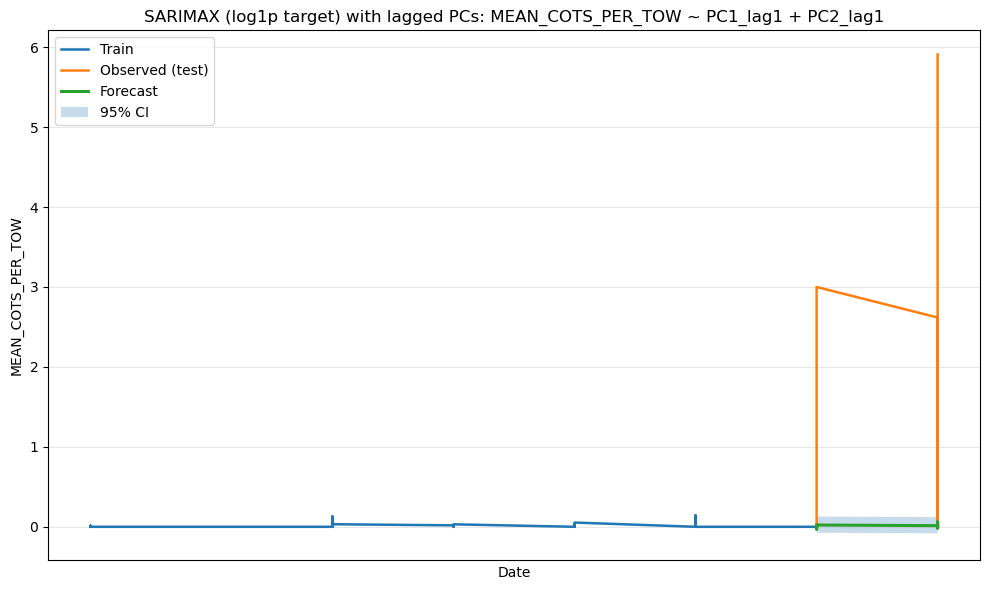

In [12]:

# Step 4 - SARIMAX with lagged principal components (PCs)
df_dates = df["date"] if "date" in df.columns else pd.Series(pd.date_range("2010", periods=len(X)))
pca_ready = pd.DataFrame({
    "date": df_dates.values,
    target_col: X[target_col].values,
    "PC1": pc_df["PC1"].values,
    "PC2": pc_df["PC2"].values
}).dropna(subset=["date", target_col, "PC1", "PC2"])

pca_ready["date"] = pd.to_datetime(pca_ready["date"])
pca_ready = (pca_ready
             .sort_values("date")
             .replace([np.inf, -np.inf], np.nan)
             .set_index("date")
             .interpolate(limit_direction="both")
             .dropna())

# Create lagged variables for PCs (previous time step)
pca_ready["PC1_lag1"] = pca_ready["PC1"].shift(1)
pca_ready["PC2_lag1"] = pca_ready["PC2"].shift(1)

# Apply log1p transform to the target variable to reduce skewness
pca_ready["y_log"] = np.log1p(pca_ready[target_col])

# Keep only rows with complete data
pca_ready = pca_ready.dropna(subset=["y_log", "PC1_lag1", "PC2_lag1"])

# Automatically detect temporal frequency (monthly or yearly)
dates = pca_ready.index.sort_values()
median_step_days = np.median(np.diff(dates.values).astype("timedelta64[D]").astype(int)) if len(dates)>=3 else 365
is_monthly = median_step_days <= 45
s = 12 if is_monthly else 0
print(f"[Lag+Log] Detected frequency: {'Monthly' if is_monthly else 'Yearly/low'}; seasonal s = {s or 'none'}")

# Split into training and testing sets (80/20)
N = len(pca_ready)
split = max(int(N*0.8), 3)
train = pca_ready.iloc[:split].copy()
test  = pca_ready.iloc[split:].copy()

exog_train = train[["PC1_lag1", "PC2_lag1"]]
exog_test  = test[["PC1_lag1", "PC2_lag1"]]

# Fit SARIMAX model on log-transformed target
order = (1,0,1)
seasonal_order = (1,0,1,s) if s else (0,0,0,0)
model = SARIMAX(train["y_log"], exog=exog_train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)
print(res.summary())

# Forecast and inverse-transform predictions
if len(test) > 0:
    fcst = res.get_forecast(steps=len(test), exog=exog_test)
    pred_log = fcst.predicted_mean
    ci_log   = fcst.conf_int()
    pred      = np.expm1(pred_log)
    ci_lower  = np.expm1(ci_log.iloc[:,0])
    ci_upper  = np.expm1(ci_log.iloc[:,1])
else:
    pred = pd.Series(dtype=float, index=train.index[-0:])
    ci_lower = pd.Series(dtype=float, index=pred.index)
    ci_upper = pd.Series(dtype=float, index=pred.index)

# Plot forecast results on the original scale
plt.figure(figsize=(10,6))
plt.plot(train.index, train[target_col], label="Train", linewidth=1.8)
if len(test) > 0:
    plt.plot(test.index,  test[target_col],  label="Observed (test)", linewidth=1.8)
    plt.plot(test.index,  pred,              label="Forecast", linewidth=2.2)
    plt.fill_between(test.index, ci_lower, ci_upper, alpha=0.25, label="95% CI")
plt.title("SARIMAX (log1p target) with lagged PCs: MEAN_COTS_PER_TOW ~ PC1_lag1 + PC2_lag1")
plt.ylabel("MEAN_COTS_PER_TOW")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("1SARIMAX_laggedPCs_logTarget_forecast.png", dpi=300)
plt.show()

print("Saved: 1SARIMAX_laggedPCs_logTarget_forecast.png")


The predicted line in the graph is almost zero while the test values have soared sharply. This indicates that the model was trained on stable samples, but the test samples contain extreme spikes. 

This is consistent with the situation in COTS data where most values are 0 and only a few have values ranging from 20 to 150. Such an uneven distribution of data is not suitable for the model.

Then, using the annual average data, a SARIMAX time series model is established, and based on the constructed synthetic future environmental scenarios, the future trend of sea star density is predicted: 

Read and clean the data, and construct the annual time series: Resample all variables by year (at the end of each December) and calculate the average to stabilize the data and make it suitable for long-term trend modeling. 

Fitting the SARIMAX model: Using environmental variables as exogenous variables, the time variation of starfish density is fitted. 

Create synthetic scenarios: Manually set trends of environmental factors (such as rising temperature, decreasing oxygen levels), construct hypothetical future change paths, use models and synthetic future scenarios to predict the density of starfish over the next 4 years, and calculate the 95% confidence interval. 

Result visualization: Generate and save the prediction graph, and print the preview table of future environmental variables.

In [13]:

# Step 5 - Annual SARIMAX + Future Scenario Forecast
CSV_PATH = Path("annually COTS_mix.csv")
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip().lstrip("\ufeff") for c in df.columns]
if "site name" in df.columns:
    df = df.rename(columns={"site name": "site"})
assert "date" in df.columns, "Missing 'date' column"
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).sort_values("date")

target_col = "MEAN_COTS_PER_TOW"
env_vars = ["eta","salt","temp","DIN","DIP","Dust","PH","Oxygen","Chl","current_speed","wind_speed"]
need_cols = [target_col] + env_vars
for c in need_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.replace([np.inf, -np.inf], np.nan)

# Aggregate data to annual mean
annual = (df.set_index("date")[need_cols]
          .resample("A-DEC")
          .mean()
          .interpolate(limit_direction="both")
          .dropna())

# Fit SARIMAX model
y = annual[target_col]
X = annual[env_vars]
model = SARIMAX(y, exog=X, order=(1,0,0), seasonal_order=(0,0,0,0),
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)
print(res.summary())

# Create synthetic future environmental scenario
N_YEARS_FUTURE = 4
last_year = annual.index[-1]
future_years = pd.date_range(last_year + pd.offsets.YearEnd(1),
                             periods=N_YEARS_FUTURE, freq="A-DEC")
t = np.arange(N_YEARS_FUTURE)
future_env = pd.DataFrame(index=future_years)

# Simulate environmental variable trends (synthetic future)
future_env["temp"] = annual["temp"].iloc[-1] + 0.2*t + 0.5*np.sin(2*np.pi*t/4)
future_env["salt"] = annual["salt"].iloc[-1] + 0.1*np.sin(2*np.pi*t/4)
future_env["eta"] = annual["eta"].iloc[-1] + 0.02*t
future_env["DIN"] = annual["DIN"].iloc[-1] + 0.05*t
future_env["DIP"] = annual["DIP"].iloc[-1] - 0.03*t
future_env["Dust"] = annual["Dust"].iloc[-1] + 0.1*np.cos(2*np.pi*t/4)
future_env["PH"] = annual["PH"].iloc[-1] - 0.01*t
future_env["Oxygen"] = annual["Oxygen"].iloc[-1] - 0.05*t
future_env["Chl"] = annual["Chl"].iloc[-1] + 0.1*np.sin(2*np.pi*t/4)
future_env["current_speed"] = annual["current_speed"].iloc[-1] + 0.02*np.sin(2*np.pi*t/4)
future_env["wind_speed"] = annual["wind_speed"].iloc[-1] + 0.05*np.cos(2*np.pi*t/4)

# Forecast future values using SARIMAX
fcst_future = res.get_forecast(steps=N_YEARS_FUTURE, exog=future_env[env_vars])
pred_future = fcst_future.predicted_mean
ci_future   = fcst_future.conf_int()

# Plot the results
plt.figure(figsize=(11,6))
plt.plot(annual.index, annual[target_col], label="Observed (annual)", linewidth=1.8)
plt.plot(pred_future.index, pred_future.values, label="Future forecast", linewidth=2.2)
plt.fill_between(pred_future.index,
                 ci_future.iloc[:,0].values,
                 ci_future.iloc[:,1].values,
                 alpha=0.25, label="95% CI")
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xlabel("Year")
plt.ylabel(target_col)
plt.title("Annual SARIMAX (no lag) — Synthetic Future Environmental Scenario")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("SARIMAX_annual_synthetic_future.png", dpi=300)
plt.show()

print("Forecast completed. Figure saved as: SARIMAX_annual_synthetic_future.png")
print("\nPreview of future environmental scenario:")
print(future_env.head())


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

Reason for error: 

1. The annual data after filtering/resampling has too few available years (the number of observations does not meet the basic requirement of maxlag < nobs). 

2. The shape of the target sequence y is two-dimensional ((n,1)) instead of one-dimensional, which results in inconsistent array concatenation dimensions during the exception handling stage. 

Based on the collected data, it is impossible to make better improvements while adhering to scientific facts. 

Therefore, we have to switch to other models/data.